In [1]:
import tensorflow as tf
import numpy as np
slim = tf.contrib.slim

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(x_train.shape)

(50000, 32, 32, 3)


In [4]:
def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [5]:
def encoder(X, reuse=False):
    with tf.variable_scope('encoder', reuse=reuse):
        nf = 128
        nh = 32

        with slim.arg_scope([slim.conv2d], kernel_size=[3,3], padding='SAME', activation_fn=tf.nn.elu):
            net = slim.conv2d(X, nf)

            net = slim.conv2d(net, nf)
            net = slim.conv2d(net, nf)
            net = slim.conv2d(net, nf*2) # 32x32

            net = slim.conv2d(net, nf*2)
            net = slim.conv2d(net, nf*2)
            net = slim.conv2d(net, nf*3, stride=2) # 16x16

            net = slim.conv2d(net, nf*3)
            net = slim.conv2d(net, nf*3)
            net = slim.conv2d(net, nf*4, stride=2) # 8x8

            net = slim.conv2d(net, nf*4)
            net = slim.conv2d(net, nf*4)
            net = slim.conv2d(net, nf*4)

        net = slim.flatten(net)
        h = slim.fully_connected(net, nh, activation_fn=None)
        return h

In [6]:
def decoder(h, reuse=False):
    with tf.variable_scope('decoder', reuse=reuse):
        nf = 128
        nh = 32
        h0 = slim.fully_connected(h, 8*8*nf, activation_fn=None) # h0
        net = tf.reshape(h0, [-1, 8, 8, nf])

        with slim.arg_scope([slim.conv2d], kernel_size=[3,3], padding='SAME', activation_fn=tf.nn.elu):
            net = slim.conv2d(net, nf)
            net = slim.conv2d(net, nf)
            net = tf.image.resize_nearest_neighbor(net, [16, 16]) # upsampling

            net = slim.conv2d(net, nf)
            net = slim.conv2d(net, nf)
            net = tf.image.resize_nearest_neighbor(net, [32, 32])

            net = slim.conv2d(net, nf)
            net = slim.conv2d(net, nf)
            net = tf.image.resize_nearest_neighbor(net, [32, 32])

            net = slim.conv2d(net, nf)
            net = slim.conv2d(net, nf)

            net = slim.conv2d(net, 3, activation_fn=None)

        return net

In [7]:
def generator(z, reuse=False):
    with tf.variable_scope('G', reuse=reuse):
        x_fake = decoder(z, reuse=reuse)

    return x_fake

In [8]:
def discriminator(X, reuse=False):
    with tf.variable_scope('D', reuse=reuse):
        h = encoder(X, reuse=reuse)
        x_recon = decoder(h, reuse=reuse)

        energy = tf.abs(X-x_recon) # L1 loss
        energy = tf.reduce_mean(energy)

    return energy

In [9]:
def solvers(lr=1e-5,beta1=0.5):
#     global_step = tf.Variable(0, trainable=False)
#     D_lr = tf.train.exponential_decay(lr,global_step,decay_steps=3000, decay_rate=0.95, staircase=True)
#     D_lr = tf.maximum(D_lr, 2e-5)
#     G_lr = tf.train.exponential_decay(lr,global_step,decay_steps=3000, decay_rate=0.5, staircase=True)
#     G_lr = tf.maximum(G_lr, 2e-5)
    D_solver=tf.train.AdamOptimizer(learning_rate=lr,beta1=beta1)
    G_solver=tf.train.AdamOptimizer(learning_rate=0.1*lr,beta1=beta1)
    return D_solver,G_solver

In [10]:
def sample_noise(batch_size, dim):
    return tf.random_uniform(shape=(batch_size,dim),minval=-1,maxval=1)

In [12]:
##### full computation graph ####
tf.reset_default_graph()
batch_size=100
dim=32
gamma=0.5
x=tf.placeholder(tf.float32,shape=[None,32,32,3])
z=sample_noise(batch_size,dim)

In [13]:
g_sample = generator(z)

In [14]:
D_real_energy = discriminator(x)
D_fake_energy = discriminator(g_sample,True)
k = tf.Variable(0., name='k', trainable=False)

In [15]:
with tf.variable_scope('D_loss'):
    D_loss = D_real_energy - k * D_fake_energy
with tf.variable_scope('G_loss'):
    G_loss = D_fake_energy
with tf.variable_scope('balance'):
    balance = gamma*D_real_energy - D_fake_energy
with tf.variable_scope('M'):
    M = D_real_energy + tf.abs(balance)

In [16]:
D_vars=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope='D')
G_vars=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope='G')

In [17]:
D_solver,G_solver = solvers()
D_train_op = D_solver.minimize(D_loss, var_list=D_vars)

In [18]:
G_train_op = G_solver.minimize(G_loss, var_list=G_vars)
with tf.variable_scope('update_k'):
    update_k = tf.assign(k, tf.clip_by_value(k +  0.0001* balance, 0., 1.))
D_train_op = update_k
# g_sample=tf.clip_by_value(g_sample,-1.,1.)

In [19]:
def show_images(images):
#     images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img)

In [24]:
def train_gan(sess,D_train_step,G_train_step,D_loss,G_loss,plot_every=250,print_every=50,batch_size=100,epochs=10):
    iterations=(int)(len(x_train)/batch_size)
    for k in range(epochs):
        for i in range(iterations-1):
#             z1 = sample_noise(batch_size,32)
            if i%plot_every==0:
            # show a generator sample
                samples=sess.run(g_sample)
                samples=np.clip(samples,-1,1)
                samples=0.5*(samples+1)
                samples=samples*255
                samples=samples.astype(int)
                fig = show_images(samples[:16])
                plt.show()
                print()
            minibatch=x_train[i*batch_size:(i+1)*batch_size] 
            minibatch=minibatch/255
            minibatch=2*minibatch-1
#             minibatch=preprocess_img(minibatch)
            _,D_loss_new = sess.run([D_train_step,D_loss],{x : minibatch})
            _,G_loss_new = sess.run([G_train_step,G_loss])
#             print(i)
            if i%print_every==0:
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(i,D_loss_new,G_loss_new))
#     print('Final images')
#     samples = sess.run(G_sample)
#     fig = show_images(samples[:16])
#     plt.show()

In [21]:
def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = False
    session = tf.Session(config=config)
    return session


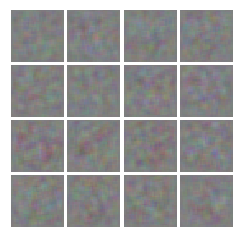


Iter: 0, D: 0.4126, G:0.04102
Iter: 50, D: 0.4343, G:0.03568
Iter: 100, D: 0.4126, G:0.03191
Iter: 150, D: 0.4529, G:0.02929
Iter: 200, D: 0.4197, G:0.02698


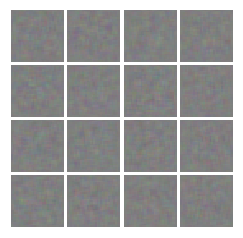


Iter: 250, D: 0.4326, G:0.025


KeyboardInterrupt: 

In [25]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    train_gan(sess,D_train_op,G_train_op,D_loss,G_loss)
    out = sess.run(g_sample)
#     saver=tf.train.Saver()
#     saver.save(sess,"model.ckpt")

In [ ]:
print(out[0].shape)

In [ ]:
out1=0.5*(out+1)

In [ ]:
out2=255*out1
out2=out2.astype(int)

In [ ]:
print(np.min(out2))

In [ ]:
plt.imshow(out2[30])